# Unifom Plane Source Simulation
This notebook gives an example of using some more functions to setup and run a simulation. In this simulation, we will use a uniform plane source to show the interaction of light with some cuboid object floating in free space.

In [57]:
import os
import time
import fdtdx
import jax
import jax.numpy as jnp
import pytreeclass as tc
from loguru import logger
import matplotlib.pyplot as plt
from IPython.display import Video

In [58]:
%matplotlib inline

# Setup of simulation scence
Let’s start with a basic setup of a simulation scene. We need to specify a random key for possible stochastic operations. This simulation will be entirely deterministic, but we still need to specify the key. Then we specify a SimulationConfig object with some basic information on how long the simulation should run and how accurate it needs to be (resolution, dtype and courant factor).

In [59]:
# Create a JAX random key for reproducibility and stochastic operations
key = jax.random.PRNGKey(seed=42)

object_list = []

# Define simulation configuration (duration, resolution, data type, etc.)
config = fdtdx.SimulationConfig(
    time=100e-15,
    resolution=100e-9,
    dtype=jnp.float32,
    courant_factor=0.99
)

Next, we specify the simulation volume. This includes the background material, which is used for all the space where we do not place objects in the following specifications.

In [60]:
volume = fdtdx.SimulationVolume(
    partial_real_shape=(12.0e-6, 12e-6, 12e-6),
    material=fdtdx.Material(  # Background material
        permittivity=1.0,
        permeability=1.0,
    )
)

As we have seen in the object placement tutorial, in FDTDX objects are placed through constraints. We create an empty list of these constraints first and then iteratively add more constraints to the list.

In [61]:
constraints = []

At first, we add the boundaries of our simulation to the constraints. We are using absorbing PML boundaries to prevent any reflections from the boundary of the simulation volume.

We could specify the boundary for each of the six sides of the simulation volume manually, but this would be tedious. Instead, we will use a handy shortcut provided by FDTDX. This creates PML boundaries on all six sides with the corresponding constraints. Here we use a thickness of 10 grid cells for the PML, which should be enough for most applications.

In [62]:
bound_cfg = fdtdx.BoundaryConfig.from_uniform_bound(thickness=10, boundary_type="pml")
bound_dict, c_list = fdtdx.boundary_objects_from_config(bound_cfg, volume)
constraints.extend(c_list)
object_list.extend(bound_dict.values())

The UniformPlaneSource is designed to model a plane wave source with uniform spatial intensity distribution. It is placed at the top (z-axis) of the simulation volume, and the light is propagated downwards, indicated by the direction "-". The polarization of the light is set to Ex-polarized, meaning the electric field oscillates in the x-direction. Unlike the Gaussian source, the spatial profile of the uniform source is constant across its entire area, without any Gaussian shaping. As a result, the light intensity is uniformly distributed across the source, making it suitable for simulations where consistent illumination is needed. Since there is no Gaussian profile to define the radius or standard deviation, the emission is typically spread across the entire defined area. The source's parameters, such as wavelength and polarization, can be adjusted to match specific simulation requirements, with the wavelength in this example set to 1.550 µm.

In [63]:
source = fdtdx.UniformPlaneSource(
    partial_grid_shape=(None, None, 1),
    partial_real_shape=(10e-6, 10e-6, None),
    fixed_E_polarization_vector=(1, 0, 0),
    wave_character=fdtdx.WaveCharacter(wavelength=1.550e-6),
    direction="-",
)

object_list.append(source)
constraints.extend(
    [
        source.place_relative_to(
            volume,
            axes=(0, 1, 2),
            own_positions=(0, 0, 1),
            other_positions=(0, 0, 1),
            margins=(0, 0, -1.5e-6),
        ),
    ]
)

Next, we place a uniform cuboid at the center of the simulaiton volume. This will make the simulation a bit more interesting to look at, because otherwise we will only see the light emitted from the source.

In [68]:
cube = fdtdx.UniformMaterialObject(
    partial_real_shape=(3e-6, 3e-6, 3e-6),  # size of the object in meters
    material=fdtdx.Material(permittivity=2.5, permeability=1.7),  # material
    name="Cube",
    color = fdtdx.colors.PINK,  # name of the object, optional
)
object_list.append(cube)
constraints.append(cube.place_at_center(volume))

In order to actually see a result from the simulation, we need to define a Detector. While the simulation function will return the E and H field after runnning the simulation, usually it is also necessary to read some physical metrics on intermediate time steps in the simulation. This is exactly what Detectors are for!

Here we use an EnergyDetector, which calculates the energy at every grid point within its volume. We also speciy a switch, which controls the time steps that the detector records. Our purpose here is to generate a video of the energy during the simulation. We do not need every single time step for this, so we only record every third time step.

The as_slices option is a memory optimization specific for creating images or videos. With this option set to True, only the values which are actually plotted will be saved instead of the whole simulation volume. If you need to read values from the whole volume, simply disable this option.

In [65]:
video_energy_detector = fdtdx.EnergyDetector(
    name="Video",
    as_slices=True,
    switch=fdtdx.OnOffSwitch(interval=3),
    exact_interpolation=True,
    num_video_workers=8,
)
object_list.append(video_energy_detector)
constraints.extend(video_energy_detector.same_position_and_size(volume))

These are all the objects we need for our simulation! Let’s resolve the constraints and plot the simulation scene to see if we made any mistakes. Note that it is good practice to split the random key to maintain randomness in JAX 

In [ ]:
key, subkey = jax.random.split(key)
objects, arrays, params, config, _ = fdtdx.place_objects(
    object_list=object_list,
    config=config,
    constraints=constraints,
    key=subkey,
)

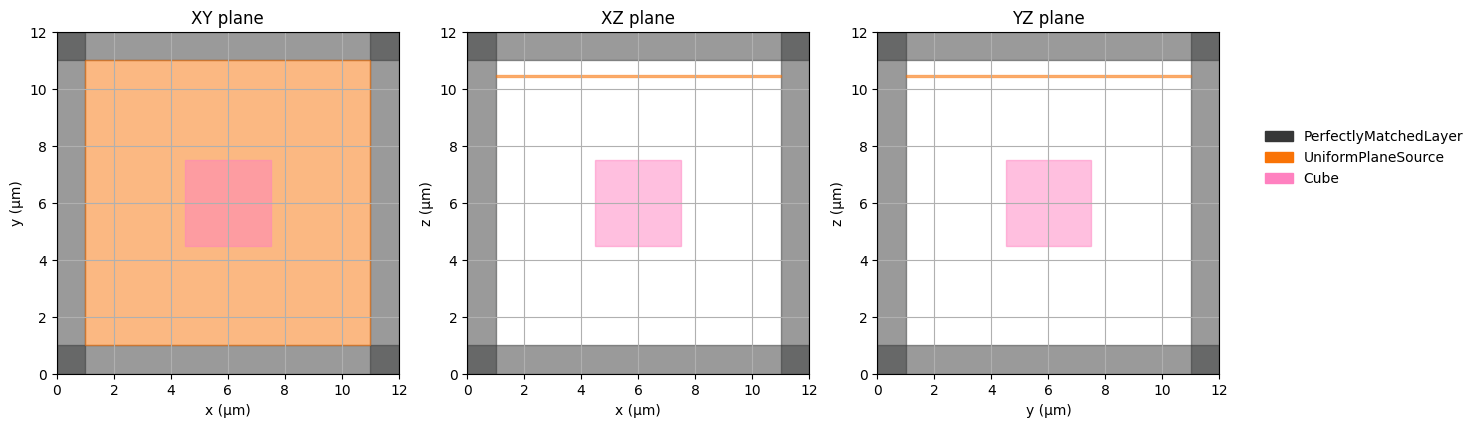

In [67]:
fig = fdtdx.plot_setup(
    config=config,
    objects=objects,
    exclude_object_list=[video_energy_detector],
)
plt.show()

# Running the simulation
Now let’s define a function that actually runs the simulation. In FDTDX, this is a two-part process.

Firstly, we call apply_params, which performs some calculations before the start of the simulation. If we have some parametric objects in the simulation, this function applies the given parameters and calculates the actual shapes of these objects. Additionally, some performance optimization are done here by calculating values for the simulation once before the simulation starts

Then, we call run_fdtd, which performs the FDTD simulation as a loop. The computation terminates as soon as the required number of time steps are reached.

In [50]:
def sim_fn(
        params: fdtdx.ParameterContainer,
        arrays: fdtdx.ArrayContainer,
        key: jax.Array,
    ):
        # Apply parameters to objects and arrays
        arrays, new_objects, _ = fdtdx.apply_params(arrays, objects, params, key)

        # Run FDTD simulation (forward)
        final_state = fdtdx.run_fdtd(
            arrays=arrays,
            objects=new_objects,
            config=config,
            key=key,
        )
        _, arrays = final_state

        return arrays

In order to execute this function, we should first compile it. JAX provides a just-in-time compilation functionality with jax.jit, which automatically compiles a function as soon as it is called the first time. We extend this a little bit here by calling .lower() and .compile() to compile the function immediately and measure the compilation time. If this seems complicated, just omit the .lower() and .compile() and everything will still work the same, just the time measurement would be wrong.

In [51]:
start_time = time.time()
jitted_loss = jax.jit(sim_fn).lower(params, arrays, key).compile()
end_time = time.time()
print(f"Compilation time: {end_time - start_time} seconds")

Compilation time: 1.493497610092163 seconds


Now we are ready to run the simulation. We can see that the simulation time is smaller than the compilation time, which can happen for small simulations. This might seem inefficient, but in pratice a few seconds usually don’t matter. And, we are now able to call the compiled function as often as we like.

In [52]:
start_time = time.time()
new_arrays = jitted_loss(params, arrays, subkey)
end_time = time.time()
print(f"Simulation runtime: {end_time - start_time} seconds")

Simulation runtime: 0.04542970657348633 seconds


# Visualizing the results of a simulation
Now we have run the simulation, but how do we visualize the results? Our goal was to generate a video of the simulation, so let’s do this.

The syntax for generating a video in a jupyter notebook is currently a bit complicated, but for actual scripts FDTDX offers some utility functions to make this easier. The reason the syntax is so complicated, is on the one hand because of the JAX-syntax which does not allow in-place updates. Additionally, the plot function saves a video to a temporary location. We can either access the video from there or move it to a more permament location

In [69]:
video_path = objects["Video"].draw_plot(new_arrays.detector_states["Video"])
print(video_path)
Video(list(video_path.values())[0], embed=True, width=720)

ERROR:2026-01-20 14:49:31,387:jax._src.xla_bridge:477: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/joshisha/nobackup/shardul/fdtdx-notebooks/.venv/lib/python3.12/site-packages/jax/_src/xla_bridge.py", line 475, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/home/joshisha/nobackup/shardul/fdtdx-notebooks/.venv/lib/python3.12/site-packages/jax_plugins/xla_cuda12/__init__.py", line 328, in initialize
    _check_cuda_versions(raise_on_first_error=True)
  File "/home/joshisha/nobackup/shardul/fdtdx-notebooks/.venv/lib/python3.12/site-packages/jax_plugins/xla_cuda12/__init__.py", line 285, in _check_cuda_versions
    local_device_count = cuda_versions.cuda_device_count()
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: jaxlib/cuda/versions_helpers.cc:113: operation cuInit(0) failed: Unknown CUDA error 303; cuGetErrorName failed. This probably means that JA

{'sliced_video': '/tmp/tmpgtpk6kgx.mp4'}
